In [6]:
def load_spectrograms(subject_id = "01", training = True):
    path_to_spec = "/home/aditis/decodingEEG/DecodeEEG/data/spectrograms/sub-"+subject_id
    if training:
        file_path = path_to_spec + '/spectrograms_train.h5'
    else:
        file_path = path_to_spec + '/spectrograms_test.h5'

    
    return file_path




def load_features(training = True):
    # load all image vectors
    path_to_features = "/home/aditis/decodingEEG/DecodeEEG/data/feature_vectors"

    # Initialize an empty list to store the loaded arrays
    data = []

    if training:
        classes = os.listdir(path_to_features+"/training/")
    else:
        classes = os.listdir(path_to_features+"/test/")

    for clas in classes:
        if training:
            feature_path  = path_to_features + "/training/" + clas
        else:
            feature_path  = path_to_features + "/test/" + clas
        files = os.listdir(feature_path)
        for file in files:
            if file.endswith('.npy'):  # Ensure it's a .npy file
                file_path = feature_path +"/"+ file
                array = np.load(file_path)  # Load the .npy file
                data.append(array)         # Append to the list

        
    # Convert the list of arrays into a matrix
    feature_matrix = np.vstack(data)  # Stack arrays vertically

    # Verify the shape
    print("Shape of feature matrix:",feature_matrix.shape)  # Output: (16540, 512) for training, (200, 512) for test

    return feature_matrix

In [5]:
# Define generator for spectrograms
def test_batch_generator(path_to_spec, feature_matrix, batch_size=20):
    num_samples = feature_matrix.shape[0]
    with h5py.File(path_to_spec, 'r') as f: 
        spectrograms = f['spectrograms'] 
        while True:
            for k in range(spectrograms.shape[1] ):  # Iterate over EEG sets (3 sets)
                spec  = spectrograms[:, k, :, :]
                for i in range(0, num_samples, batch_size):
                    batch_end = min(i + batch_size, num_samples)
                    spectro_batch = spec[i:batch_end, :, :, :]
                    features = feature_matrix[i:batch_end, :]
                    print(spectro_batch.shape)
                    print(features.shape)
                    yield (spectro_batch, features)
            break

In [9]:
import sys
from pathlib import Path
import os
import h5py
from tensorflow.keras.models import load_model
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

#load data for one subject
test_eeg_data = load_spectrograms(training = False) # by default subject 1
test_feature_matrix = load_features(training=False) 


# Load the model
model = load_model("/home/aditis/decodingEEG/DecodeEEG/data/results/cnn_model_simple_trained.h5")

# Generate test spectrograms and evaluate
batch_size = 64
steps = np.ceil(test_feature_matrix.shape[0] / batch_size)


# Evaluate the model
loss, mae = model.evaluate(test_batch_generator(test_eeg_data,test_feature_matrix, batch_size), steps=steps)
print(f"Test Loss: {loss}, Test MAE: {mae}")

predicted_features = []
for batch_data,_ in test_batch_generator(test_eeg_data, test_feature_matrix, batch_size):
    batch_predictions = model.predict(batch_data)
    predicted_features.append(batch_predictions)

predicted_features = np.concatenate(predicted_features, axis=0)

similarity_scores = cosine_similarity(predicted_features, test_feature_matrix)
print(f"Average Cosine Similarity: {np.mean(similarity_scores)}")

Shape of feature matrix: (200, 512)
(64, 17, 26, 26)
(64, 512)
(64, 17, 26, 26)
(64, 512)
1/4 [======>.......................] - ETA: 1s - loss: 0.7773 - mae: 0.6423(64, 17, 26, 26)
(64, 512)
(8, 17, 26, 26)
(8, 512)
4/4 [==============================] - 1s 6ms/step - loss: 0.7914 - mae: 0.6449
(64, 17, 26, 26)
(64, 512)
Test Loss: 0.7913960218429565, Test MAE: 0.6449230313301086
(64, 17, 26, 26)
(64, 512)
2/2 [==============================] - 0s 4ms/step
(64, 17, 26, 26)
(64, 512)
2/2 [==============================] - 0s 3ms/step
(64, 17, 26, 26)
(64, 512)
2/2 [==============================] - 0s 14ms/step
(8, 17, 26, 26)
(8, 512)
1/1 [==============================] - 0s 101ms/step
(64, 17, 26, 26)
(64, 512)
2/2 [==============================] - 0s 4ms/step
(64, 17, 26, 26)
(64, 512)
2/2 [==============================] - 0s 33ms/step
(64, 17, 26, 26)
(64, 512)
2/2 [==============================] - 0s 19ms/step
(8, 17, 26, 26)
(8, 512)
1/1 [==============================] - 0s 

In [13]:
predicted_features.shape

(16000, 512)

In [18]:
# Reshape the matrix to group every 80 vectors together
reshaped_features = predicted_features.reshape(-1, 80, 512)
print(reshaped_features.shape)

# Compute the mean along the new axis (axis=1)
averaged_features = reshaped_features.mean(axis=1)

# Verify the shape
print(averaged_features.shape)  # Output should be (200, 512)

(200, 80, 512)
(200, 512)


(200, 200)
(200,)
Average Cosine Similarity: 0.7128292918205261


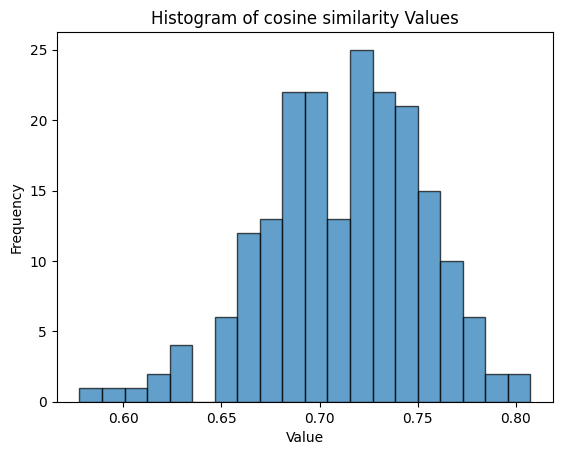

In [28]:
import matplotlib.pyplot as plt
similarity_scores = cosine_similarity(averaged_features, test_feature_matrix)
print(similarity_scores.shape)

# Extract the diagonal elements to get the cosine similarity for corresponding vectors
cosine_similarities = np.diag(similarity_scores)

# Verify the shape
print(cosine_similarities.shape)  # Output should be (200,)
print(f"Average Cosine Similarity: {np.mean(similarity_scores)}")

# Calculate histogram data
bins = 20  # Number of bins
hist, bin_edges = np.histogram(cosine_similarities, bins=bins)

#print("Histogram frequencies:", hist)
#print("Bin edges:", bin_edges)

# Plot the histogram
plt.hist(cosine_similarities, bins=bins, edgecolor='black', alpha=0.7)
plt.title("Histogram of cosine similarity Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [19]:
test_feature_matrix.shape

(200, 512)

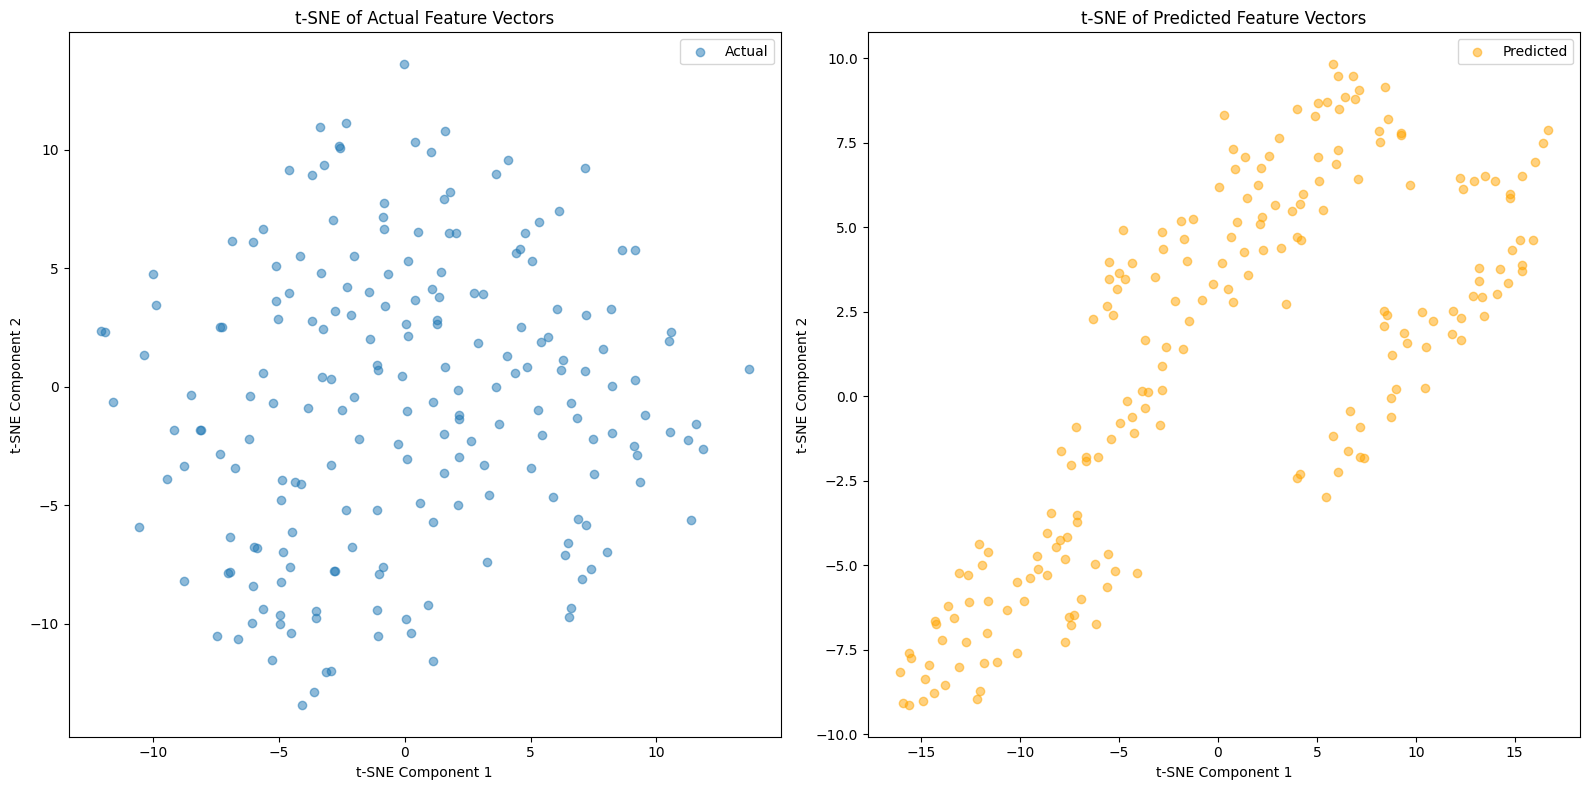

In [21]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# Apply t-SNE to actual and predicted features separately
tsne_actual = TSNE(n_components=2, random_state=42)
tsne_predicted = TSNE(n_components=2, random_state=42)

tsne_results_actual = tsne_actual.fit_transform(test_feature_matrix)
tsne_results_predicted = tsne_predicted.fit_transform(averaged_features)

# Plot side-by-side t-SNE results
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot t-SNE for actual features
axes[0].scatter(tsne_results_actual[:, 0], tsne_results_actual[:, 1], alpha=0.5, label='Actual')
axes[0].set_title('t-SNE of Actual Feature Vectors')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].legend()

# Plot t-SNE for predicted features
axes[1].scatter(tsne_results_predicted[:, 0], tsne_results_predicted[:, 1], alpha=0.5, label='Predicted', color='orange')
axes[1].set_title('t-SNE of Predicted Feature Vectors')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].legend()

plt.tight_layout()
plt.show()